In [1]:
import copy
import pickle

import BeamWithSprings as bm
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandarallel import pandarallel
from scipy import stats

import ajf_plts

SEED = ajf_plts.get_seed("5_demo_simulations.ipynb")

plt.style.use(["./ajf_plts/base.mplstyle", "./ajf_plts/legend_frame.mplstyle"])

In [32]:
beam = construct_model_LB()

I = beam.I
depth = beam.depth
ELEM_MID_X_VALS = beam.ELEM_MID_X_VALS
elem_dam = beam.node_to_elem(beam.x_pos_to_node(34/3.0))

lc = 1.5 * depth
np.abs(ELEM_MID_X_VALS - ELEM_MID_X_VALS[elem_dam]) < lc

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

In [31]:
beam.x_pos_to_node(34.0/3.0)

34

In [33]:
beam.NODE_X_VALS

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05,
       1.1 , 1.15, 1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45, 1.5 , 1.55, 1.6 ,
       1.65, 1.7 ])

In [38]:
side_span_length = 11.4  # m
center_span_length = 19.0  # m
bridge_length = center_span_length + 2.0 * side_span_length

ELEM_LEN = 0.1


def construct_model_GH(piers_type='pinroller'):
    # Bridge Properties
    bridge_width = 8  # m

    # Slab Properties
    depth_slab = 0.65  # m
    area_slab = bridge_width * depth_slab
    I_slab = (bridge_width * depth_slab**3) / 12.0

    # Setup beam object
    n_side_span_elems = int(side_span_length // ELEM_LEN)
    n_side_span_elems += n_side_span_elems % 2  # ensures even no. of elems

    n_cent_span_elems = int(center_span_length // ELEM_LEN)
    n_cent_span_elems += n_cent_span_elems % 2  # ensures even no. of elems

    L1 = np.linspace(
        0.0,
        side_span_length,
        n_side_span_elems + 1,
    )
    L2 = np.linspace(
        side_span_length,
        side_span_length + center_span_length,
        n_cent_span_elems + 1,
    )
    L3 = np.linspace(
        side_span_length + center_span_length,
        bridge_length,
        n_side_span_elems + 1,
    )
    L = np.diff(np.concatenate([L1, L2[1:], L3[1:]]))

    beam = bm.Beam(len(L), L)

    beam.density = 2400.0
    beam.E = 30e9

    beam.area = area_slab
    beam.I = I_slab

    beam.depth = depth_slab

    beam.damp_ratio = 0.018  # based on modal test

    # ADD ROT. SPRINGS AT PIERS
    for x in [side_span_length, side_span_length + center_span_length]:
        if piers_type == 'pinroller':
            beam.pin_node(beam.x_pos_to_node(x))
        elif piers_type == 'column':
            beam.add_column_support(
                beam_node=beam.x_pos_to_node(x),
                E_column=None,
                I_column=3.1 * 0.9**3 / 12.0,
                A_column=3.1 * 0.9,
                L_column=2.5,
                rho_column=2400,
            )

    # PIN ENDS
    beam.pin_node(beam.x_pos_to_node(0))  # LHS END
    beam.pin_node(beam.x_pos_to_node(bridge_length))  # RHS END

    beam.update_model()

    return beam


def construct_model_LB():
    beam = bm.Beam(int(34//ELEM_LEN), ELEM_LEN)

    beam.density = 2446.0
    beam.E = 30e9

    beam.area = 10.0
    beam.I = 6.0

    beam.depth = 2.2

    beam.damp_ratio = 0.018  # based on modal test

    # PIN ENDS
    beam.pin_node(beam.x_pos_to_node(0))  # LHS END
    beam.pin_node(beam.x_pos_to_node(np.sum(beam.L)))  # RHS END

    beam.update_model()

    return beam


beam_LB = construct_model_LB()
beam_GH_pin = construct_model_GH(piers_type='pinroller')
beam_GH_col = construct_model_GH(piers_type='column')

In [39]:
P=np.array([1e3]) # 1kN
S=np.array([0.0]) # m

LHS: d=0.0 abs.max.RIL= 1.00
     d=0.2 abs.max.RIL= 1.15
                change=+14.70%

RHS: d=0.0 abs.max.RIL= 1.00
     d=0.2 abs.max.RIL= 1.05
                change=+5.45%



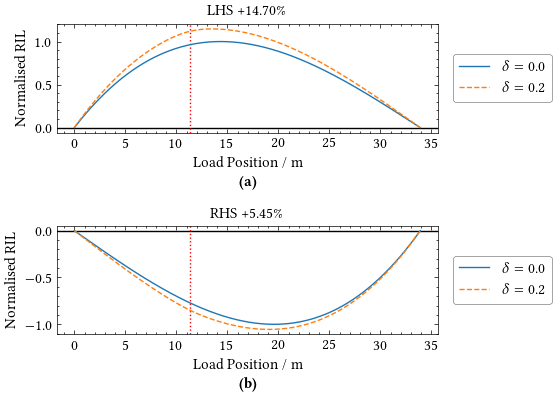

In [117]:
%matplotlib widget

figsize = (ajf_plts.text_width_inches, 0.5*ajf_plts.text_height_inches)

fig, axes = plt.subplots(figsize=figsize,
                         ncols=1,
                         nrows=2)

res = dict()
x_dam = beam_LB.L.sum() / 3.0
healthy_delta = 0.0
damaged_delta = 0.2
for delta in [healthy_delta, damaged_delta]:
    beam_LB.reset_crack_damage()
    beam_LB.add_crack_damage(x_dam, delta)
    beam_LB.update_model()
    res[delta] = beam_LB.perform_static_sim(P, S)

for ax in axes:
    ax.axhline(0.0, ls='-', c='k')
    ax.axvline(x_dam, ls=':', c='r')
    
cond_ls = {healthy_delta:'-',damaged_delta:'--'}

for i, (pos, name) in enumerate(zip([0.0, beam_LB.L.sum()], ['LHS', 'RHS'])):
    dof =  beam_GH_pin.x_pos_to_rot_dof(pos)
    healthy_absmax = np.max(np.abs(res[healthy_delta][1][dof]))
    damaged_absmax = np.max(np.abs(res[damaged_delta][1][dof]))
    axes[i].plot(res[healthy_delta][0], res[healthy_delta][1][dof]/healthy_absmax, ls=cond_ls[healthy_delta], label=rf'$\delta={healthy_delta}$') #steps_LB, rot )#/ np.max(np.abs(rot)))
    axes[i].plot(res[damaged_delta][0], res[damaged_delta][1][dof]/healthy_absmax, ls=cond_ls[damaged_delta], label=rf'$\delta={damaged_delta}$') #steps_LB, rot )#/ np.max(np.abs(rot)))
    axes[i].set_title(f'{name} {100.0*(damaged_absmax-healthy_absmax)/healthy_absmax:+2.2f}\\%')
    
    print(f'{name}: d=0.0 abs.max.RIL={healthy_absmax/healthy_absmax: 2.2f}')
    print(f'{len(name)*" "}  d=0.2 abs.max.RIL={damaged_absmax/healthy_absmax: 2.2f}')
    print(f'{len(name)*" "}             change={(damaged_absmax-healthy_absmax)/healthy_absmax:+2.2%}')
    print()

for ax in axes:
    ax.set_xlabel('Load Position / m')
    ax.set_ylabel(r'Normalised RIL')# / \unit{\radian\per\kilo\newton')
    ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5))
    
ajf_plts.caption_axes(axes)
fig.tight_layout()

L Abut.: d=0.0 abs.max.RIL= 1.00
         d=0.2 abs.max.RIL= 1.01
                    change=+0.53%

L Pier: d=0.0 abs.max.RIL= 1.00
        d=0.2 abs.max.RIL= 1.05
                   change=+5.48%

R Pier: d=0.0 abs.max.RIL= 1.00
        d=0.2 abs.max.RIL= 1.00
                   change=+0.46%

R Abut.: d=0.0 abs.max.RIL= 1.00
         d=0.2 abs.max.RIL= 1.00
                    change=+0.03%



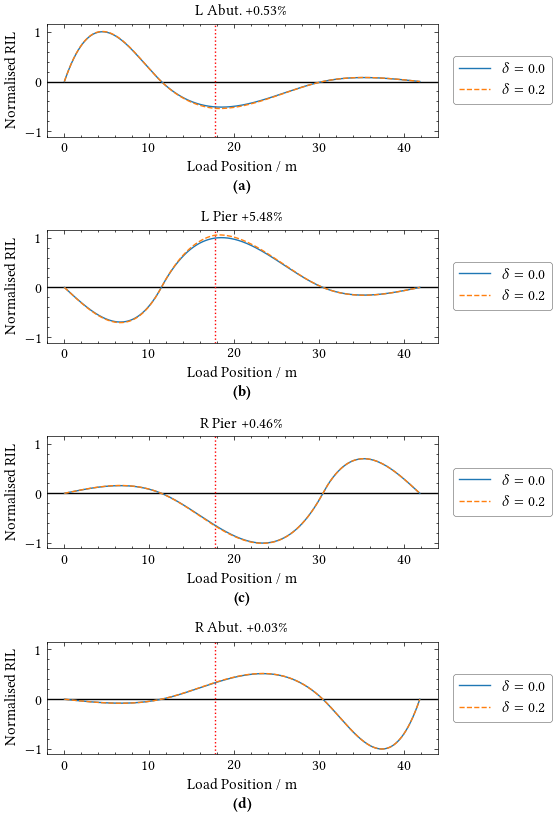

In [122]:
%matplotlib widget

figsize = (ajf_plts.text_width_inches, ajf_plts.text_height_inches)
fig, axes = plt.subplots(figsize=figsize,
                         sharey=True,
                         ncols=1,
                         nrows=4)

res = dict()
x_dam = side_span_length+center_span_length/3.0
healthy_delta = 0.0
damaged_delta = 0.2
for delta in [healthy_delta, damaged_delta]:
    beam_GH_pin.reset_crack_damage()
    beam_GH_pin.add_crack_damage(x_dam, delta)
    beam_GH_pin.update_model()
    res[delta] = beam_GH_pin.perform_static_sim(P, S)

for ax in axes:
    ax.axhline(0.0, ls='-', c='k')
    ax.axvline(x_dam, ls=':', c='r')
    
cond_ls = {healthy_delta:'-',damaged_delta:'--'}

for i, (pos, name) in enumerate(zip([0.0, side_span_length, side_span_length+center_span_length, bridge_length], ['L Abut.', 'L Pier', 'R Pier', 'R Abut.'])):
    dof =  beam_GH_pin.x_pos_to_rot_dof(pos)
    healthy_absmax = np.max(np.abs(res[healthy_delta][1][dof]))
    damaged_absmax = np.max(np.abs(res[damaged_delta][1][dof]))
    axes[i].plot(res[healthy_delta][0], res[healthy_delta][1][dof]/healthy_absmax, ls=cond_ls[healthy_delta], label=rf'$\delta={healthy_delta}$') #steps_LB, rot )#/ np.max(np.abs(rot)))
    axes[i].plot(res[damaged_delta][0], res[damaged_delta][1][dof]/healthy_absmax, ls=cond_ls[damaged_delta], label=rf'$\delta={damaged_delta}$') #steps_LB, rot )#/ np.max(np.abs(rot)))
    axes[i].set_title(f'{name} {100.0*(damaged_absmax-healthy_absmax)/healthy_absmax:+2.2f}\\%')
    
    print(f'{name}: d=0.0 abs.max.RIL={healthy_absmax/healthy_absmax: 2.2f}')
    print(f'{len(name)*" "}  d=0.2 abs.max.RIL={damaged_absmax/healthy_absmax: 2.2f}')
    print(f'{len(name)*" "}             change={(damaged_absmax-healthy_absmax)/healthy_absmax:+2.2%}')
    print()

for ax in axes:
    ax.set_xlabel('Load Position / m')
    ax.set_ylabel(r'Normalised RIL')# / \unit{\radian\per\kilo\newton')
    ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5))
    
ajf_plts.caption_axes(axes)
fig.tight_layout()

L Abut.: d=0.0 abs.max.RIL= 1.00
         d=0.2 abs.max.RIL= 1.14
                    change=+14.03%

L Pier: d=0.0 abs.max.RIL= 1.00
        d=0.2 abs.max.RIL= 1.02
                   change=+1.60%

R Pier: d=0.0 abs.max.RIL= 1.00
        d=0.2 abs.max.RIL= 1.00
                   change=+0.04%

R Abut.: d=0.0 abs.max.RIL= 1.00
         d=0.2 abs.max.RIL= 1.00
                    change=+0.00%



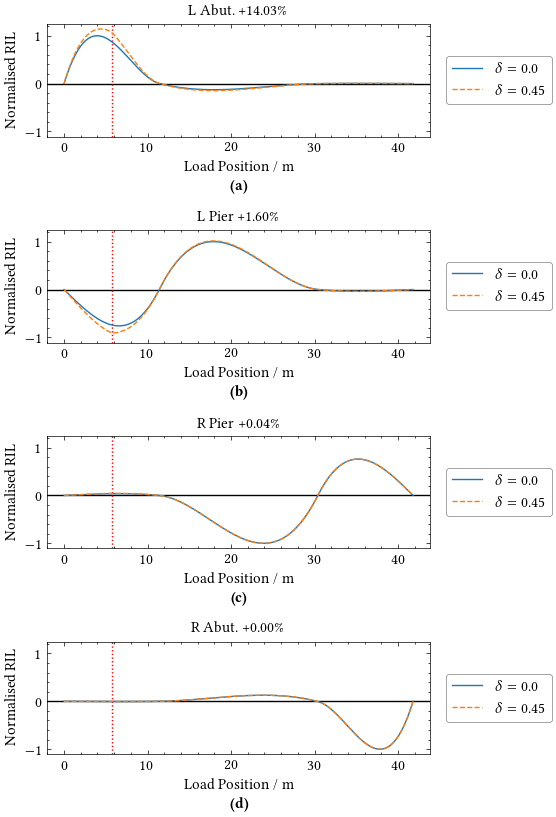

In [131]:
%matplotlib widget

figsize = (ajf_plts.text_width_inches, ajf_plts.text_height_inches)
fig, axes = plt.subplots(figsize=figsize,
                         sharey=True,
                         ncols=1,
                         nrows=4)

res = dict()
x_dam = side_span_length/2.0
healthy_delta = 0.0
damaged_delta = 0.45
for delta in [healthy_delta, damaged_delta]:
    beam_GH_col.reset_crack_damage()
    beam_GH_col.add_crack_damage(x_dam, delta)
    beam_GH_col.update_model()
    res[delta] = beam_GH_col.perform_static_sim(P, S)

for ax in axes:
    ax.axhline(0.0, ls='-', c='k')
    ax.axvline(x_dam, ls=':', c='r')
    
cond_ls = {healthy_delta:'-',damaged_delta:'--'}

for i, (pos, name) in enumerate(zip([0.0, side_span_length, side_span_length+center_span_length, bridge_length], ['L Abut.', 'L Pier', 'R Pier', 'R Abut.'])):
    dof =  beam_GH_pin.x_pos_to_rot_dof(pos)
    healthy_absmax = np.max(np.abs(res[healthy_delta][1][dof]))
    damaged_absmax = np.max(np.abs(res[damaged_delta][1][dof]))
    axes[i].plot(res[healthy_delta][0], res[healthy_delta][1][dof]/healthy_absmax, ls=cond_ls[healthy_delta], label=rf'$\delta={healthy_delta}$') #steps_LB, rot )#/ np.max(np.abs(rot)))
    axes[i].plot(res[damaged_delta][0], res[damaged_delta][1][dof]/healthy_absmax, ls=cond_ls[damaged_delta], label=rf'$\delta={damaged_delta}$') #steps_LB, rot )#/ np.max(np.abs(rot)))
    axes[i].set_title(f'{name} {100.0*(damaged_absmax-healthy_absmax)/healthy_absmax:+2.2f}\\%')
    
    print(f'{name}: d=0.0 abs.max.RIL={healthy_absmax/healthy_absmax: 2.2f}')
    print(f'{len(name)*" "}  d=0.2 abs.max.RIL={damaged_absmax/healthy_absmax: 2.2f}')
    print(f'{len(name)*" "}             change={(damaged_absmax-healthy_absmax)/healthy_absmax:+2.2%}')
    print()

for ax in axes:
    ax.set_xlabel('Load Position / m')
    ax.set_ylabel(r'Normalised RIL')# / \unit{\radian\per\kilo\newton')
    ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5))
    
ajf_plts.caption_axes(axes)
fig.tight_layout()